In [354]:
import importlib
import utils
import transformers
import model
import losses

from sklearn.metrics import mean_squared_error

In [355]:
from model import *
from utils import *

In [356]:
importlib.reload(utils)
importlib.reload(transformers)
importlib.reload(model)
importlib.reload(losses)

<module 'losses' from 'd:\\Documents\\machinelearning\\cgm-paper\\src\\losses.py'>

In [357]:
print("Current working directory: ", os.getcwd())

Current working directory:  d:\Documents\machinelearning\cgm-paper\src


In [358]:
raw_dir = "../data/raw"
tuning_dir = "../data/tuning"

In [359]:
assert os.path.exists(raw_dir), "Raw data directory not found"
assert os.path.exists(tuning_dir), "Tuning data directory not found"

In [360]:
dataset = load_data(raw_dir)

Found 22 files in ../data/raw
train (139415, 47)
test (32912, 47)


In [361]:
val_dataset = load_data(tuning_dir)

Found 2 files in ../data/tuning
train (13630, 43)
test (3002, 43)


In [362]:
for key in dataset.keys():
    val_dataset[key] = reduce_classes(val_dataset[key])
    dataset[key] = reduce_classes(dataset[key])

In [363]:
dataset.get("train")['Time'].isnull().sum()

0

In [364]:
train_data = get_train_dataset(dataset['train'])
test_data = get_any_dataset(dataset['test'], dataset['train'])

      CGM  month  day  hour  minute  weekday  year  cgm_velo  change  \
24  129.0      5   19    13      35        2  2027  0.003333     1.0   
25  127.0      5   19    13      40        2  2027  0.000000     0.0   
26  124.0      5   19    13      45        2  2027 -0.006667    -2.0   
27  123.0      5   19    13      50        2  2027 -0.010000    -3.0   
28  124.0      5   19    13      55        2  2027 -0.003333    -1.0   

    upper_band  ...  extreme_CGM_80  extreme_CGM_85  extreme_CGM_90  \
24  198.092207  ...               0               0               0   
25  198.840303  ...               0               0               0   
26  198.288080  ...               0               0               0   
27  196.078435  ...               0               0               0   
28  192.197842  ...               0               0               0   

    extreme_CGM_95  wCGM(1)     wCGM(2)     wCGM(3)  wCGM(4)     wCGM(5)  \
24               0    129.0  128.333333  127.666667    127.8  12

The tuning data will be merged with the training data and be fitted into the pipeline to be used for the validation data

In [365]:
tuning_data = get_tuning_dataset(val_dataset['train'], dataset['train'])
val_data = get_any_dataset(val_dataset['test'], tuning_data)

In [366]:
trainX, trainY = train_data.drop(["CGM"], axis = 1), train_data["CGM"]
trainX.shape, trainY.shape

((120010, 20), (120010,))

In [367]:
testX, testY = test_data.drop(["CGM"], axis = 1), test_data["CGM"]
testX.shape, testY.shape

((26845, 20), (26845,))

In [368]:
testX.tail(5)

,month,day,hour,minute,weekday,year,cgm_velo,change,upper_band,lower_band,extreme_CGM_80,extreme_CGM_85,extreme_CGM_90,extreme_CGM_95,wCGM(1),wCGM(2),wCGM(3),wCGM(4),wCGM(5),wCGM(6)
32907,1,23,20,55,6,2022,-0.006667,-2.0,231.007617,121.742383,0,0,0,0,150.0,151.333333,152.666667,154.0,155.666667,156.619048
32908,1,23,21,0,6,2022,-0.003333,-1.0,226.195461,121.387873,0,0,0,0,149.0,149.666667,150.833333,152.1,153.400000,155.000000
32909,1,23,21,5,6,2022,-0.003333,-1.0,221.190096,121.393237,0,0,0,0,148.0,148.666667,149.333333,150.4,151.600000,152.857143
32910,1,23,21,10,6,2022,0.010000,3.0,217.096903,121.403097,0,0,0,0,151.0,149.000000,149.000000,149.4,150.266667,151.333333
32911,1,23,21,15,6,2022,-0.006667,-2.0,213.194437,121.305563,0,0,0,0,149.0,150.333333,149.166667,149.1,149.400000,150.142857


In [369]:
model = HybridModel()
model.fit(trainX, trainY, testX, testY, eval = True, tune = False)

Base fitted with columns: Index(['month', 'day', 'hour', 'minute', 'weekday', 'year', 'cgm_velo',
       'change', 'upper_band', 'lower_band', 'extreme_CGM_80',
       'extreme_CGM_85', 'extreme_CGM_90', 'extreme_CGM_95', 'wCGM(1)',
       'wCGM(2)', 'wCGM(3)', 'wCGM(4)', 'wCGM(5)', 'wCGM(6)', 'direction'],
      dtype='object')
Base: (16.343257505850314, 4.042679495810955, 0.07745652072445076)
Base + Residuals: (16.264420586680743, 4.0329171311447425, 0.0771612046960515) Change: 4.2841620243252265%


In [370]:
from sklearn.metrics import mean_squared_error


def plot_forecast(y, n_steps = 12, lookback = 12, use_confi = True):
    result = model.forecast(testX.iloc[:-n_steps], n_steps = n_steps, return_X = False, use_confi = use_confi)
    forecast = result["forecasts"]
    actual = y.iloc[-n_steps - lookback:].reset_index(drop = True)
    plt.figure(figsize = (15, 5))
    if use_confi:
        confi_int = result["confi_forecasts"]
        plt.plot(np.arange(lookback, len(forecast) + lookback), confi_int['Median'], label = "Median", color = "red")
        plt.fill_between(np.arange(lookback, len(forecast) + lookback), confi_int["Lower"], confi_int["Upper"], color = "red", alpha = 0.15)

    plt.plot(actual, label = "Actual", color = "blue")
    plt.plot(np.arange(lookback, len(forecast) + lookback), forecast, label = "Forecast", color = "red")
    plt.legend()
    plt.show()
    
    print("RMSE", np.sqrt(mean_squared_error(actual.iloc[lookback:], forecast)))

Forecasting: 100%|██████████| 24/24 [00:04<00:00,  5.36it/s]


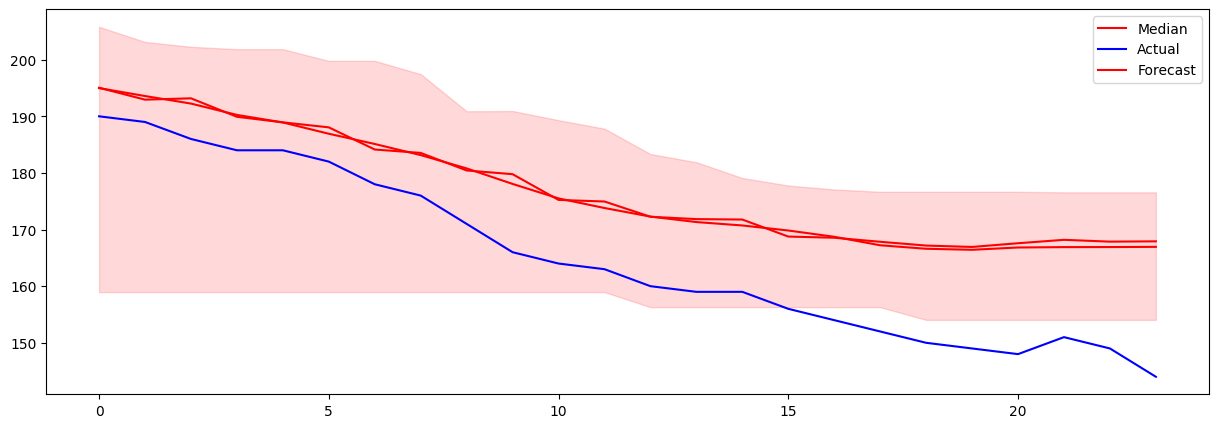

RMSE 12.712753305459724


In [373]:
plot_forecast(testY, n_steps = 24, lookback= 0, use_confi = True)